In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
#Configuracion de parámetros
width_shape = 224
height_shape = 224
num_classes = 2
epochs = 100
batch_size = 32 

In [3]:
#path del dataset
train_data_dir = 'data/model1_data/train'  
validation_data_dir = 'data/model1_data/evaluation'

In [4]:
#data gens
train_datagen = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='binary')

validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='binary')

Found 660 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [5]:
#cantidad de fotos de entrenamiento.
nb_train_samples = 660
#cantidad de fotos validacion
nb_validation_samples = 98

image_input = Input(shape=(width_shape, height_shape, 3))

#base convolucional
conv_base = VGG16(input_tensor=image_input, include_top=False,weights='imagenet')

conv_base.summary()     

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
#call backs
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/model-{epoch:02d}-{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    verbose=1
)    
    
#learning rate NO CORRER POR AHORA
"""

cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.1,
    patience=10,
    verbose=1,
    min_lr=0.00001
)
"""
"""
cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    min_delta=0.001,
    patience=10, # para despues de 10 epocas que no mejora el error
    verbose=1
)
"""

cb_csvlogger = tf.keras.callbacks.CSVLogger(
    filename='training_log.csv',
    separator=',',
    append=False
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________


In [8]:
###########
#model 1
###########

#congelamos capa convolucional
for layer in conv_base.layers:
    layer.trainable = False
    
model = Sequential()
model.add(conv_base)
model.add(keras.layers.Flatten())
# antes: model.add(keras.layers.Dense(256,activation='relu')) # preguntar: 16*16----> menos parámetros, menos capas con menos neuronas. 4}4}4}4}4}4

model.add(keras.layers.Dense(4,activation='relu')) 
model.add(keras.layers.Dense(4,activation='relu'))
model.add(keras.layers.Dense(4,activation='relu'))
model.add(keras.layers.Dense(4,activation='relu'))
model.add(keras.layers.Dense(4,activation='relu'))
model.add(keras.layers.Dense(4,activation='relu'))
model.add(keras.layers.Dense(4,activation='relu'))
model.add(keras.layers.Dense(4,activation='relu'))
# 4 * 8
model.add(keras.layers.Dense(1,activation='sigmoid')) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 100356    
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_9 (Dense)              (None, 4)                

In [9]:
#compilamos modelo y entrenamos
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [24]:
model1_history = model.fit_generator(  
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        steps_per_epoch=nb_train_samples//batch_size,
        validation_steps=nb_validation_samples//batch_size,
        callbacks=[cb_checkpoint, cb_csvlogger])
model.save("modeltrainedcallbacks1.h5")

Epoch 1/50
20/20 [==============================] - 54s 3s/step - loss: 0.6907 - accuracy: 0.5382 - val_loss: 0.6903 - val_accuracy: 0.5417

Epoch 00001: saving model to checkpoints/model-01-0.54.hdf5
Epoch 2/50
20/20 [==============================] - 53s 3s/step - loss: 0.6902 - accuracy: 0.5430 - val_loss: 0.6902 - val_accuracy: 0.5417

Epoch 00002: saving model to checkpoints/model-02-0.54.hdf5
Epoch 3/50
20/20 [==============================] - 53s 3s/step - loss: 0.6891 - accuracy: 0.5525 - val_loss: 0.6912 - val_accuracy: 0.5312

Epoch 00003: saving model to checkpoints/model-03-0.53.hdf5
Epoch 4/50
20/20 [==============================] - 54s 3s/step - loss: 0.6897 - accuracy: 0.5462 - val_loss: 0.6890 - val_accuracy: 0.5521

Epoch 00004: saving model to checkpoints/model-04-0.55.hdf5
Epoch 5/50
20/20 [==============================] - 55s 3s/step - loss: 0.6894 - accuracy: 0.5478 - val_loss: 0.6900 - val_accuracy: 0.5417

Epoch 00005: saving model to checkpoints/model-05-0.54.


Epoch 00041: saving model to checkpoints/model-41-0.54.hdf5
Epoch 42/50
20/20 [==============================] - 58s 3s/step - loss: 0.6895 - accuracy: 0.5430 - val_loss: 0.6897 - val_accuracy: 0.5417

Epoch 00042: saving model to checkpoints/model-42-0.54.hdf5
Epoch 43/50
20/20 [==============================] - 58s 3s/step - loss: 0.6875 - accuracy: 0.5541 - val_loss: 0.6897 - val_accuracy: 0.5417

Epoch 00043: saving model to checkpoints/model-43-0.54.hdf5
Epoch 44/50
20/20 [==============================] - 58s 3s/step - loss: 0.6898 - accuracy: 0.5414 - val_loss: 0.6878 - val_accuracy: 0.5521

Epoch 00044: saving model to checkpoints/model-44-0.55.hdf5
Epoch 45/50
20/20 [==============================] - 57s 3s/step - loss: 0.6892 - accuracy: 0.5446 - val_loss: 0.6916 - val_accuracy: 0.5312

Epoch 00045: saving model to checkpoints/model-45-0.53.hdf5
Epoch 46/50
20/20 [==============================] - 54s 3s/step - loss: 0.6898 - accuracy: 0.5414 - val_loss: 0.6878 - val_accurac

In [8]:
#############
#model 2
#############

image_input = Input(shape=(width_shape, height_shape, 3))

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

last_layer = model.get_layer('fc2').output

out = Dense(1, activation='sigmoid', name='output')(last_layer)

custom_vgg_model = Model(image_input, out)

for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False
    

custom_vgg_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
custom_vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
"""
entrenar fc1-fc2.
"""

In [9]:
model2_history = custom_vgg_model.fit_generator(  
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        steps_per_epoch=nb_train_samples//batch_size,
        validation_steps=nb_validation_samples//batch_size,
        callbacks=[cb_checkpoint, cb_csvlogger]
)
custom_vgg_model.save("modeldos1CALLBACKSv2.h5")

/home/agustin/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
20/20 [==============================] - 65s 3s/step - loss: 0.6527 - accuracy: 0.6528 - val_loss: 0.4025 - val_accuracy: 0.8438

Epoch 00001: saving model to checkpoints/model-01-0.84.hdf5
Epoch 2/100
20/20 [==============================] - 65s 3s/step - loss: 0.4578 - accuracy: 0.7879 - val_loss: 0.4718 - val_accuracy: 0.8125

Epoch 00002: saving model to checkpoints/model-02-0.81.hdf5
Epoch 3/100
20/20 [==============================] - 60s 3s/step - loss: 0.4131 - accuracy: 0.8202 - val_loss: 0.4183 - val_accuracy: 0.8229

Epoch 00003: saving model to checkpoints/model-03-0.82.hdf5
Epoch 4/100
20/20 [==============================] - 60s 3s/step - loss: 0.3802 - accuracy: 0.8404 - val_loss: 0.4167 - val_accuracy: 0.8333

Epoch 00004: saving model to checkpoints/model-04-0.83.hdf5
Epoch 5/100
20/20 [==============================] - 60s 3s/step - loss: 0.4040 - accuracy: 0.8160 - val_loss: 0.3600 - val_accuracy: 0.8125

Epoch 00005: saving model to checkpoints/model-05-

20/20 [==============================] - 53s 3s/step - loss: 0.2242 - accuracy: 0.9305 - val_loss: 0.3777 - val_accuracy: 0.8542

Epoch 00081: saving model to checkpoints/model-81-0.85.hdf5
Epoch 82/100
20/20 [==============================] - 53s 3s/step - loss: 0.2606 - accuracy: 0.8786 - val_loss: 0.4022 - val_accuracy: 0.8646

Epoch 00082: saving model to checkpoints/model-82-0.86.hdf5
Epoch 83/100
20/20 [==============================] - 53s 3s/step - loss: 0.2555 - accuracy: 0.9019 - val_loss: 0.5629 - val_accuracy: 0.8646

Epoch 00083: saving model to checkpoints/model-83-0.86.hdf5
Epoch 84/100
20/20 [==============================] - 57s 3s/step - loss: 0.1977 - accuracy: 0.9261 - val_loss: 0.4706 - val_accuracy: 0.8646

Epoch 00084: saving model to checkpoints/model-84-0.86.hdf5
Epoch 85/100
20/20 [==============================] - 52s 3s/step - loss: 0.2567 - accuracy: 0.9172 - val_loss: 0.5355 - val_accuracy: 0.8542

Epoch 00085: saving model to checkpoints/model-85-0.85.hdf

In [11]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

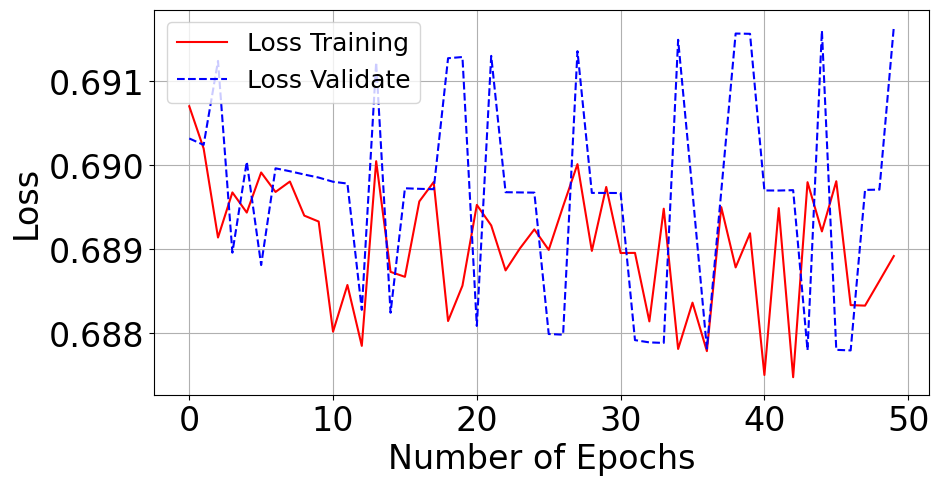

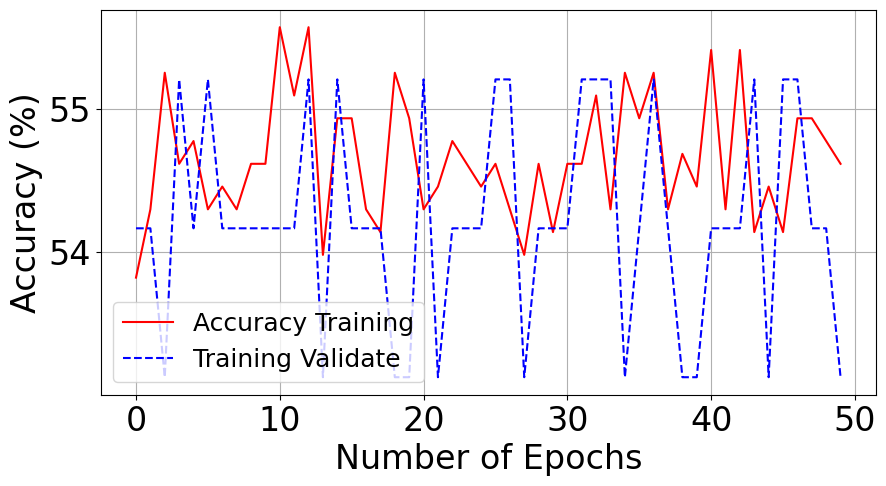

In [26]:

"""
Gráficas de entrenamiento de Modelo 1

"""
plotTraining(model1_history,epochs,"loss")
plotTraining(model1_history,epochs,"accuracy")
plotTraining(model1_history,epochs,"val_loss")
plotTraining(model1_history,epochs,"val_accuracy")



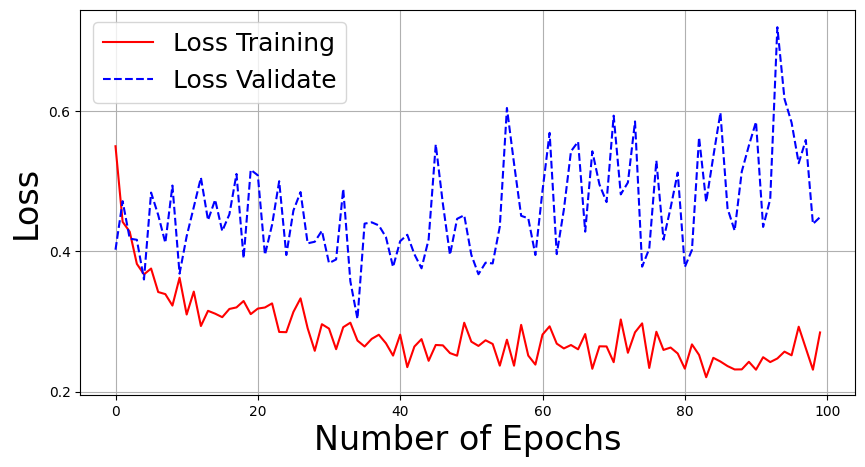

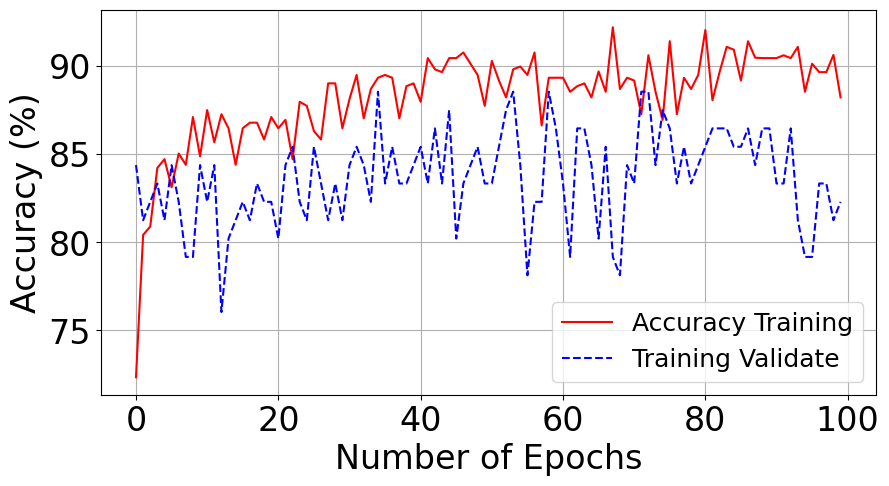

In [12]:
"""
Gráficas de entrenamiento de Modelo 2

"""

plotTraining(model2_history,epochs,"loss")
plotTraining(model2_history,epochs,"accuracy")
plotTraining(model2_history,epochs,"val_loss")
plotTraining(model2_history,epochs,"val_accuracy")


In [ ]:
"""
#curva ROC-----> cambio de treshold.

test_data_dir = 'data/'  

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)


custom_Model= load_model("model_VGG16.h5")

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


"""


In [ ]:
"""
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model

names = ["fantasmas","identificadas"]

modelt = load_model("model3nov_VGG16.h5")
#modelt = custom_vgg_model


allfiles= os.listdir("data/model1_data/test/identificada")    

for image in allfiles:
    imaget_path = "data/model1_data/test/identificada/"+image
    imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
    xt = np.asarray(imaget)
    xt=preprocess_input(xt)
    xt = np.expand_dims(xt,axis=0)
    preds = modelt.predict(xt)
    print(image +": ",end="")
    print(names[np.argmax(preds)])

"""


    """plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()"""

Found 100 images belonging to 2 classes.


/home/agustin/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

           0     0.5600    1.0000    0.7179        56
           1     0.0000    0.0000    0.0000        44

    accuracy                         0.5600       100
   macro avg     0.2800    0.5000    0.3590       100
weighted avg     0.3136    0.5600    0.4021       100

[[56  0]
 [44  0]]


/home/agustin/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/agustin/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/agustin/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

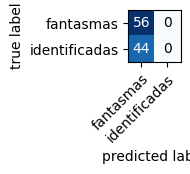

In [19]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


"""
Evaluacion modelo 1
"""


names = ["fantasmas","identificadas"]


test_data_dir = 'data/model1_data/test'  

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='binary', 
    shuffle=False)

custom_Model= load_model("modeltrainedcallbacks1.h5") # AQUIBORRE LOS CALLBACKS PERO IGUAL ESTABA RARO ESTE

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes

matc=confusion_matrix(y_real, y_pred)



plot_confusion_matrix(conf_mat=matc, figsize=(2,2), class_names = names, show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))


print(matc)


Found 100 images belonging to 2 classes.


/home/agustin/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[56  0]
 [44  0]]
              precision    recall  f1-score   support

           0     0.5600    1.0000    0.7179        56
           1     0.0000    0.0000    0.0000        44

    accuracy                         0.5600       100
   macro avg     0.2800    0.5000    0.3590       100
weighted avg     0.3136    0.5600    0.4021       100



/home/agustin/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/agustin/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/agustin/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

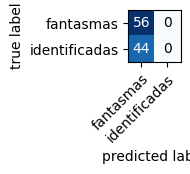

In [14]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline



"""
Evaluacion modelo 2
"""


names = ["fantasmas","identificadas"]


test_data_dir = 'data/model1_data/test'  

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = 1,
    class_mode=None, 
    shuffle=False)

custom_Model= load_model("checkpoints/model-79-0.83.hdf5")

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)


plot_confusion_matrix(conf_mat=matc, figsize=(2,2), class_names = names, show_normed=False)
plt.tight_layout()


print(matc)
print(metrics.classification_report(y_real,y_pred, digits = 4))

In [7]:
#Confusion Matrix and Classification Report

"""
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model


names = ["fantasmas","identificadas"]


test_data_dir = 'data/model1_data/test'  

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 

custom_Model= load_model("modelnuevodos.h5")


"""





"""

Y_pred = custom_Model.predict_generator(test_generator, test_generator.samples // batch_size+1)

y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=names))


"""


Found 100 images belonging to 2 classes.


TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
"""
cambiar a sigmoid
acurracy y f1 score: para dos clases reducimos matriz
revisar codigo


repito proceso para misma cámara y otros meses.
comparar resultados por epoca.
evaluar 

"""

In [10]:
"""from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt



names = ["fantasmas","identificadas"]


test_data_dir = 'data/model1_data/test'  


test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_data_dir, # Put your path here
     target_size=(width_shape, height_shape),
    batch_size=batch_size,
    shuffle=False)

#test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

custom_Model= load_model("modelnuevouno.h5",compile=False)


predictions = custom_Model.predict_generator(test_data_generator)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())  




matc=confusion_matrix(true_classes, predicted_classes)
print(matc)
#report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(true_classes,predicted_classes)

#print(report)  
"""

Found 100 images belonging to 2 classes.


/home/agustin/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[56  0]
 [44  0]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
